In [ ]:
!python -m pip install zipcodes

In [1]:
import os
import sys
sys.path.insert(0, "../")

In [2]:
import pandas as pd
import numpy as np
import data_processing.utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

## Loading Full LendingClub Data

It is expected that the accepted and rejected loan datasets live in a subdirectory called ```data``` in the root directory.

In [ ]:
DATASET_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data/')
ACCEPTED_LOANS_FN = "Lending_Club_Accepted_2014_2018.csv"
REJECTED_LOANS_FN = "Lending_Club_Rejected_2014_2018.csv"

accepted = pd.read_csv(DATASET_PATH + ACCEPTED_LOANS_FN)
rejected = pd.read_csv(DATASET_PATH + REJECTED_LOANS_FN)

In [ ]:
accepted.head()

## Exploring the Accepted Loans Dataset

### Subsampling By Loan Amount

For the sake of initial exploration and establishing the cleaning methodology, we sample from the accepted loans data to construct a representative subset of the data. We do this by sampling from a discrete approximation of the distribution of ```loan_amnt``` category to apply a 50x reduction in the dataset size.

In [3]:
TEST_PATH = os.path.join(os.path.dirname(os.getcwd()), 'data_processing/test_files/')
SAMPLE_BY_LOAN_FN = "sample_by_loan_amt.csv"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 160)

In [4]:
sampled_by_loan = pd.read_csv(TEST_PATH + SAMPLE_BY_LOAN_FN)
sampled_by_loan.head()

/home/acowlagi/.conda/envs/torch_py39/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (19,59,118) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68533595,NaN,12000.0,12000.0,12000.0,36 months,10.78,391.62,B,B4,Public Affairs Specialist,1 year,RENT,98000.0,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,993xx,WA,24.04,0.0,Feb-2002,690.0,694.0,0.0,33.0,61.0,15.0,1.0,20462.0,62.8,39.0,w,0.0,0.0,13349.665589,13349.67,12000.0,1349.67,0.0,0.00,0.0000,Apr-2017,7884.96,NaN,Jun-2017,754.0,750.0,0.0,69.0,1.0,Individual,NaN,NaN,NaN,0.0,5930.0,374585.0,0.0,4.0,1.0,3.0,9.0,82819.0,66.0,1.0,2.0,12597.0,65.0,32600.0,1.0,1.0,0.0,5.0,26756.0,3884.0,83.9,0.0,0.0,147.0,166.0,9.0,9.0,8.0,9.0,69.0,15.0,69.0,4.0,3.0,5.0,3.0,6.0,17.0,8.0,14.0,5.0,15.0,0.0,0.0,0.0,2.0,87.2,66.7,0.0,0.0,478544.0,103281.0,24100.0,120544.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68495092,NaN,8650.0,8650.0,8650.0,36 months,19.89,320.99,E,E3,Program Coordinator,8 years,RENT,55000.0,Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,462xx,IN,25.49,0.0,Mar-2005,675.0,679.0,4.0,NaN,30.0,18.0,1.0,9568.0,46.0,19.0,w,0.0,0.0,9190.490000,9190.49,8650.0,540.49,0.0,0.00,0.0000,May-2016,8251.42,NaN,Jun-2016,639.0,635.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,18926.0,6.0,1.0,0.0,1.0,19.0,9358.0,51.0,12.0,16.0,653.0,46.0,20750.0,2.0,0.0,5.0,17.0,1051.0,1375.0,45.0,0.0,0.0,129.0,95.0,0.0,0.0,0.0,8.0,NaN,0.0,NaN,0.0,2.0,17.0,2.0,2.0,2.0,17.0,17.0,13.0,18.0,NaN,0.0,0.0,12.0,100.0,50.0,1.0,0.0,38998.

<AxesSubplot:>

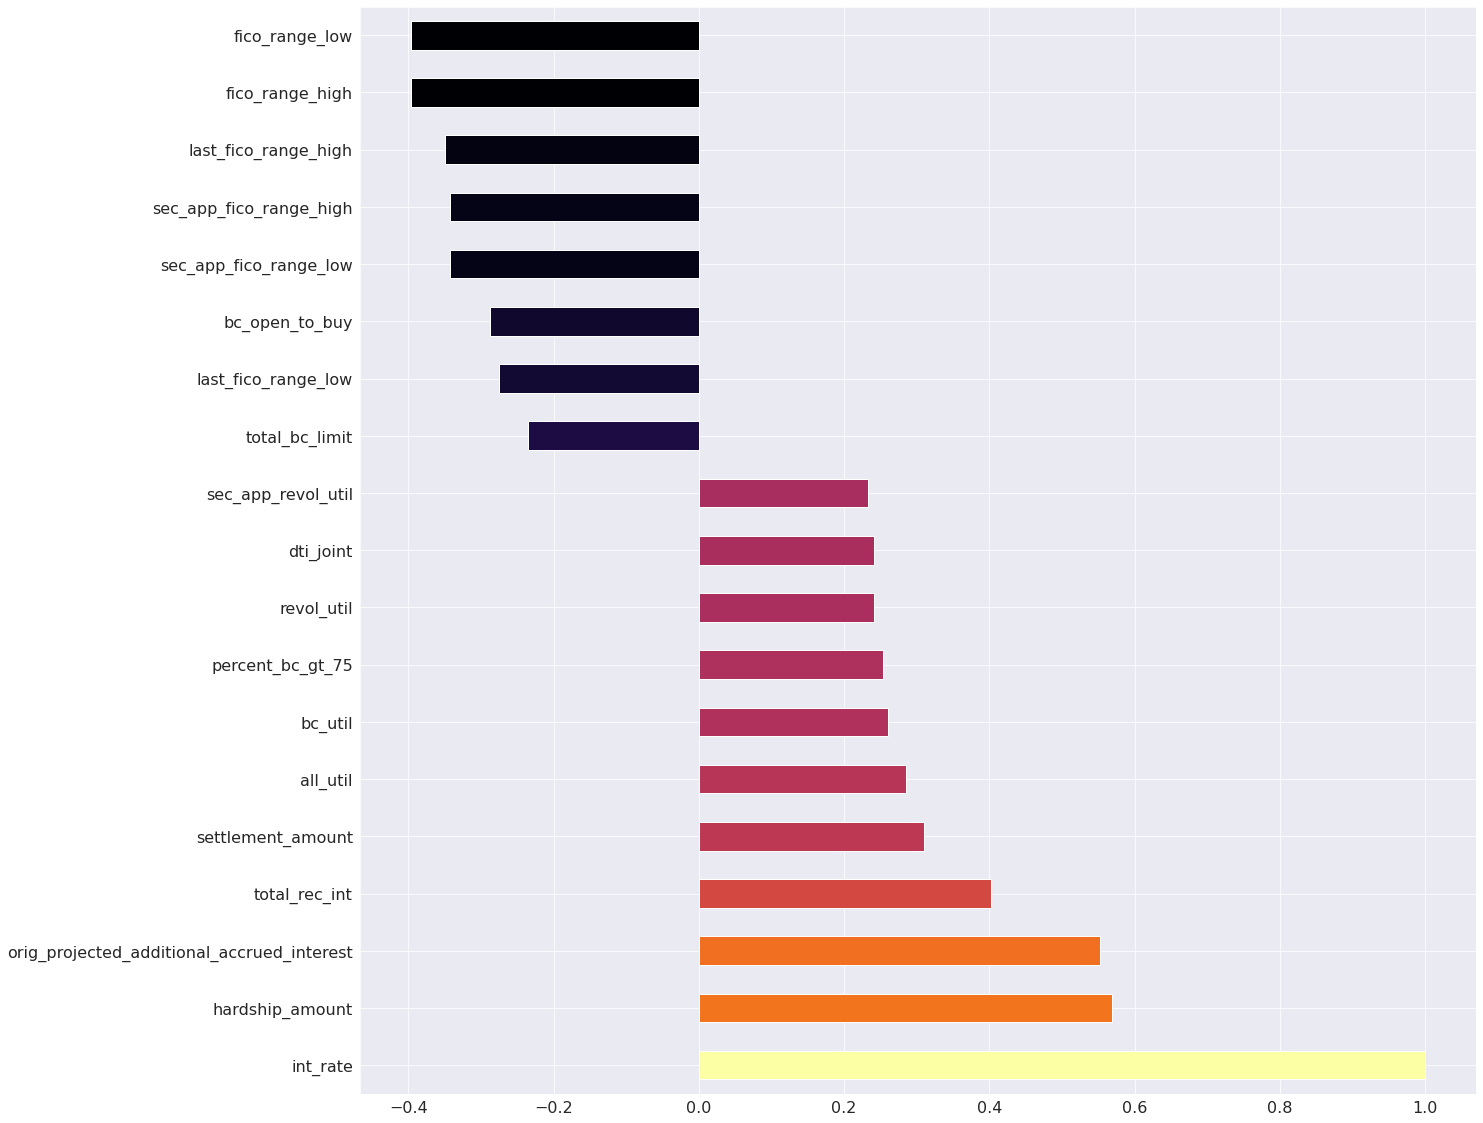

In [5]:
int_rate_corrs = (sampled_by_loan.corr()['int_rate'][abs(sampled_by_loan.corr()['int_rate']) > 0.2]).sort_values(ascending = False)
scaled_corrs = (int_rate_corrs.values - int_rate_corrs.values.min()) / (int_rate_corrs.values.max() - int_rate_corrs.values.min())
int_rate_corrs.plot.barh(figsize = (20, 20), fontsize = 16, color = plt.cm.inferno(scaled_corrs))

We now explore the structure of various features of initial interest. We drop the remaining columns for this section. In general, we have extracted features that are known prior to/immediately after loan origination, rather than at the end of the lifetime of the loan. We also include the loan status. 

In [6]:
cat_vars_of_interest = ["term", "grade", "sub_grade", "emp_title", "emp_length", "home_ownership", "verification_status", "purpose", "addr_state", 
    "initial_list_status", "application_type", "hardship_flag", "loan_status"
]
num_vars_of_interest = list(set([
    "loan_amnt", "funded_amnt", "funded_amnt_inv", "int_rate", "installment", "issue_d", "annual_inc", "dti", "fico_range_low", "fico_range_high", 
    "revol_bal", "revol_util", "open_acc", "zip_code", "delinq_2yrs", "inq_last_6mths", "total_acc", "mths_since_last_delinq", "mths_since_last_record", "mths_since_rcnt_il",
    "last_credit_pull_d", "open_il_12m", "open_il_24m", "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util",
    "total_rev_hi_lim", "inq_fi", "total_cu_tl", "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy", "bc_util", "num_accts_ever_120_pd",
    "num_actv_bc_tl", "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_sats", "num_il_tl", "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0", "tot_hi_cred_lim", 
    "pct_tl_nvr_dlq", "percent_bc_gt_75", "total_bal_ex_mort", "total_bc_limit","total_il_high_credit_limit", "mths_since_last_major_derog", "mths_since_recent_bc",
    "mths_since_recent_bc_dlq", "mths_since_recent_inq", "mths_since_recent_revol_delinq"
]))


In [7]:
sampled_by_loan = sampled_by_loan[num_vars_of_interest + cat_vars_of_interest]
sampled_by_loan.head()

,num_il_tl,fico_range_high,delinq_2yrs,int_rate,bc_util,mths_since_last_delinq,inq_fi,max_bal_bc,funded_amnt_inv,bc_open_to_buy,issue_d,num_bc_sats,dti,il_util,revol_util,mths_since_recent_bc,num_op_rev_tl,mths_since_recent_revol_delinq,percent_bc_gt_75,open_rv_12m,tot_hi_cred_lim,loan_amnt,total_bc_limit,total_rev_hi_lim,total_cu_tl,last_credit_pull_d,num_actv_rev_tl,num_bc_tl,total_acc,total_bal_il,num_rev_accts,fico_range_low,acc_open_past_24mths,total_bal_ex_mort,zip_code,mths_since_last_major_derog,funded_amnt,open_acc,annual_inc,open_rv_24m,avg_cur_bal,mths_since_recent_inq,open_il_12m,num_rev_tl_bal_gt_0,installment,total_il_high_credit_limit,mths_since_recent_bc_dlq,mths_since_rcnt_il,mths_since_last_record,open_il_24m,all_util,inq_last_6mths,revol_bal,num_accts_ever_120_pd,num_sats,pct_tl_nvr_dlq,num_actv_bc_tl,inq_last_12m,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type,hardship_flag,loan_status
0,17.0,694.0,0.0,10.78,83.9,33.0,1.0,12597.0,12000.0,3884.0,Dec-2015,3.0,24.04,66.0,62.8,9.0,8.0,69.0,66.7,1.0,478544.0,12000.0,24100.0,32600.0,1.0,Jun-2017,5.0,6.0,39.0,82819.0,14.0,690.0,5.0,103281.0,993xx,69.0,12000.0,15.0,98000.0,2.0,26756.0,15.0,1.0,5.0,391.62,120544.0,69.0,9.0,61.0,3.0,65.0,0.0,20462.0,4.0,15.0,87.2,3.0,0.0,36 months,B,B4,Public Affairs Specialist,1 year,RENT,Not Verified,debt_consolidation,WA,w,Individual,N,Fully Paid
1,2.0,679.0,0.0,19.89,45.0,NaN,2.0,653.0,8650.0,1375.0,Dec-2015,2.0,25.49,51.0,46.0,8.0,17.0,NaN,50.0,12.0,38998.0,8650.0,2750.0,20750.0,0.0,Jun-2016,17.0,2.0,19.0,9358.0,17.0,675.0,17.0,18926.0,462xx,NaN,8650.0,18.0,55000.0,16.0,1051.0,0.0,0.0,13.0,320.99,18248.0,NaN,19.0,30.0,1.0,46.0,4.0,9568.0,0.0,18.0,100.0,2.0,5.0,36 months,E,E3,Program Coordinator,8 years,RENT,Verified,debt_consolidation,IN,w,Individual,N,Fully Paid
2,7.0,749.0,0.0,7.49,54.3,NaN,1.0,8937.0,25000.0,17538.0,Dec-2015,5.0,26.02,58.0,54.3,13.0,5.0,NaN,20.0,0.0,373572.0,25000.0,38400.0,38400.0,0.0,Apr-2017,3.0,6.0,19.0,47194.0,9.0,745.0,2.0,68056.0,226xx,NaN,25000.0,9.0,109000.0,1.0,33976.0,0.0,0.0,3.0,777.55,82117.0,NaN,13.0,NaN,1.0,57.0,1.0,20862.0,0.0,9.0,100.0,3.0,1.0,36 months,A,A4,Sales Manager,10+ years,MORTGAGE,Not Verified,debt_consolidation,VA,w,Individual,N,Fully Paid
3,1.0,729.0,2.0,14.85,14.1,18.0,0.0,367.0,4225.0,2233.0,Dec-2015,3.0,15.22,22.0,24.6,26.0,5.0,18.0,0.0,0.0,21822.0,4225.0,2600.0,4300.0,0.0,Dec-2017,2.0,3.0,6.0,3830.0,5.0,725.0,0.0,4888.0,672xx,NaN,4225.0,6.0,35000.0,0.0,815.0,14.0,0.0,2.0,146.16,17522.0,NaN,47.0,NaN,0.0,22.0,0.0,1058.0,0.0,6.0,66.7,1.0,0.0,36 months,C,C5,mechanic,5 years,RENT,Source Verified,debt_consolidation,KS,w,Individual,N,Charged Off
4,3.0,704.0,0.0,12.88,77.0,NaN,0.0,7386.0,1400.0,7940.0,Dec-2015,8.0,34.95,67.0,67.2,28.0,12.0,NaN,75.0,0.0,372109.0,1400.0,34500.0,56300.0,2.0,Sep-2018,11.0,11.0,24.0,37430.0,17.0,700.0,4.0,75258.0,275xx,NaN,1400.0,17.0,64000.0,2.0,19159.0,18.0,1.0,11.0,47.10,55501.0,NaN,2.0,NaN,2.0,67.0,0.0,37828.0,0.0,17.0,100.0,7.0,0.0,36 months,C,C2,Logistics Manager,3 years,MORTGAGE,Not Verified,other,NC,w,Individual,N,Fully Paid


In [8]:
missing = sampled_by_loan.isna().sum()
missing /= sampled_by_loan.shape[0]
missing *=100
missing = missing.to_frame().rename(columns={0:'Percent Of Missing Values'})
missing

,Percent Of Missing Values
num_il_tl,0.000000
fico_range_high,0.000000
delinq_2yrs,0.000000
int_rate,0.000000
bc_util,1.164394
mths_since_last_delinq,50.465265
inq_fi,31.261385
max_bal_bc,31.261385
funded_amnt_inv,0.000000
bc_open_to_buy,1.115159


In [9]:
sampled_by_loan["emp_length"].unique()

array(['1 year', '8 years', '10+ years', '5 years', '3 years', '9 years',
       '4 years', '6 years', '2 years', '< 1 year', nan, '7 years'],
      dtype=object)

We now make some plots to check the distribution of the different variables, so the cleaning stage is most productive

#### Numerical Features

In [10]:
numerical_features = sampled_by_loan.select_dtypes(include=['int64','float64']).columns.values
other_features = sampled_by_loan.select_dtypes(include=['object'])

numerical_features

array(['num_il_tl', 'fico_range_high', 'delinq_2yrs', 'int_rate',
       'bc_util', 'mths_since_last_delinq', 'inq_fi', 'max_bal_bc',
       'funded_amnt_inv', 'bc_open_to_buy', 'num_bc_sats', 'dti',
       'il_util', 'revol_util', 'mths_since_recent_bc', 'num_op_rev_tl',
       'mths_since_recent_revol_delinq', 'percent_bc_gt_75',
       'open_rv_12m', 'tot_hi_cred_lim', 'loan_amnt', 'total_bc_limit',
       'total_rev_hi_lim', 'total_cu_tl', 'num_actv_rev_tl', 'num_bc_tl',
       'total_acc', 'total_bal_il', 'num_rev_accts', 'fico_range_low',
       'acc_open_past_24mths', 'total_bal_ex_mort',
       'mths_since_last_major_derog', 'funded_amnt', 'open_acc',
       'annual_inc', 'open_rv_24m', 'avg_cur_bal',
       'mths_since_recent_inq', 'open_il_12m', 'num_rev_tl_bal_gt_0',
       'installment', 'total_il_high_credit_limit',
       'mths_since_recent_bc_dlq', 'mths_since_rcnt_il',
       'mths_since_last_record', 'open_il_24m', 'all_util',
       'inq_last_6mths', 'revol_bal', 'num

In [11]:
print(len(numerical_features))
sampled_by_loan[numerical_features].describe()

55


,num_il_tl,fico_range_high,delinq_2yrs,int_rate,bc_util,mths_since_last_delinq,inq_fi,max_bal_bc,funded_amnt_inv,bc_open_to_buy,num_bc_sats,dti,il_util,revol_util,mths_since_recent_bc,num_op_rev_tl,mths_since_recent_revol_delinq,percent_bc_gt_75,open_rv_12m,tot_hi_cred_lim,loan_amnt,total_bc_limit,total_rev_hi_lim,total_cu_tl,num_actv_rev_tl,num_bc_tl,total_acc,total_bal_il,num_rev_accts,fico_range_low,acc_open_past_24mths,total_bal_ex_mort,mths_since_last_major_derog,funded_amnt,open_acc,annual_inc,open_rv_24m,avg_cur_bal,mths_since_recent_inq,open_il_12m,num_rev_tl_bal_gt_0,installment,total_il_high_credit_limit,mths_since_recent_bc_dlq,mths_since_rcnt_il,mths_since_last_record,open_il_24m,all_util,inq_last_6mths,revol_bal,num_accts_ever_120_pd,num_sats,pct_tl_nvr_dlq,num_actv_bc_tl,inq_last_12m
count,40622.000000,40622.000000,40622.000000,40622.000000,40149.000000,20122.000000,27923.000000,27923.000000,40622.000000,40169.000000,40622.000000,40595.000000,23835.000000,40595.000000,40197.000000,40622.000000,13861.000000,40157.000000,27923.000000,4.062200e+04,40622.000000,40622.000000,40622.000000,27923.000000,40622.000000,40622.000000,40622.000000,27923.000000,40622.000000,40622.000000,40622.000000,40622.000000,11100.000000,40622.000000,40622.000000,4.062200e+04,27923.000000,40621.000000,36177.000000,27923.000000,40622.000000,40622.000000,40622.000000,9708.000000,27062.00000,6907.000000,27923.000000,27919.000000,40622.000000,40622.000000,40622.000000,40622.000000,40622.000000,40622.000000,27923.000000
mean,8.474423,702.315716,0.320885,13.016267,56.870326,34.494881,0.999749,5825.924471,15181.559223,11857.681620,4.809463,19.119201,69.082987,49.516155,24.423937,8.341662,35.732848,41.097187,1.311965,1.781516e+05,15186.276525,23684.479272,35288.389050,1.514307,5.663335,7.661612,24.288169,35595.129499,14.043548,698.315568,4.609670,51733.410763,44.328649,15186.276525,11.783393,7.832073e+04,2.806969,13360.778317,6.989081,0.678366,5.602211,448.875696,44444.088376,39.623094,21.44350,71.686695,1.553952,56.861456,0.550416,16795.099035,0.518143,11.739304,93.989161,3.684161,2.048705
std,7.410487,33.073739,0.886263,4.874614,28.648460,22.000156,1.481870,5915.544238,9288.291414,17454.408493,3.140370,14.708373,23.882915,24.750324,31.971050,4.843187,22.488916,36.165645,1.534661,1.785255e+05,9290.192340,23931.433835,34974.412526,2.722296,3.453474,4.732256,12.215184,43941.903930,8.229270,33.073082,3.223653,49814.550767,21.665417,9290.192340,5.822492,5.949613e+04,2.656030,16231.061063,5.946621,0.927429,3.344764,270.441946,45442.334742,22.953139,26.39655,25.550533,1.567449,20.998032,0.850023,22423.222574,1.367721,5.807124,9.187799,2.355986,2.400769
min,0.000000,664.000000,0.000000,5.310000,0.000000,0.000000,0.000000,0.000000,750.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,660.000000,0.000000,0.000000,0.000000,1000.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,30.120000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,679.000000,0.000000,9.440000,34.200000,16.000000,0.000000,2274.000000,8000.000000,1859.000000,3.000000,12.090000,55.000000,30.700000,6.000000,5.000000,17.000000,0.000000,0.000000,5.123925e+04,8000.000000,8400.000000,14800.000000,0.000000,3.000000,4.000000,15.000000,8596.000000,8.000000,675.000000,2.000000,21075.000000,27.000000,8000.000000,8.000000,4.700000e+04,1.000000,3058.000000,2.000000,0.000000,3.000000,252.880000,15145.750000,20.000000,7.00000,55.000000,0.000000,43.000000,0.000000,5939.250000,0.000000,8.000000,91.000000,2.000000,0.000000
50%,7.000000,694.000000,0.000000,12.610000,58.800000,31.000000,0.000000,4437.000000,13000.000000,5700.000000,4.000000,18.100000,72.000000,49.100000,14.000000,7.000000,33.000000,33.300000,1.000000,1.139045e+05,13000.000000,16500.000000,25900.000

This identifies values in the dataset that are spurious/misleading, like occasional ```dti``` entries of 9999. We remove such values by replacing them with the state average dti.

In [12]:
sampled_by_loan["addr_state"].unique()

array(['WA', 'IN', 'VA', 'KS', 'NC', 'SC', 'NY', 'AZ', 'PA', 'MD', 'RI',
       'IL', 'DC', 'SD', 'CO', 'NM', 'OH', 'FL', 'TX', 'GA', 'MA', 'CA',
       'MI', 'NJ', 'LA', 'TN', 'WV', 'AR', 'OR', 'CT', 'OK', 'NE', 'AL',
       'MO', 'WI', 'NH', 'MN', 'VT', 'NV', 'MT', 'WY', 'ME', 'AK', 'DE',
       'UT', 'KY', 'ND', 'MS', 'HI', 'ID'], dtype=object)

In [13]:
sampled_by_loan, num_vars_of_interest, cat_vars_of_interest = utils.clean_accepted_df(sampled_by_loan, numeric_cols= num_vars_of_interest, categorical_cols= cat_vars_of_interest, one_hot_threshold=30)
sampled_by_loan.head()

grade
sub_grade
home_ownership
verification_status
purpose
loan_status


,num_il_tl,fico_range_high,delinq_2yrs,int_rate,bc_util,mths_since_last_delinq,inq_fi,max_bal_bc,funded_amnt_inv,bc_open_to_buy,issue_d,num_bc_sats,dti,il_util,revol_util,mths_since_recent_bc,num_op_rev_tl,mths_since_recent_revol_delinq,percent_bc_gt_75,open_rv_12m,tot_hi_cred_lim,loan_amnt,total_bc_limit,total_rev_hi_lim,total_cu_tl,last_credit_pull_d,num_actv_rev_tl,num_bc_tl,total_acc,total_bal_il,num_rev_accts,fico_range_low,acc_open_past_24mths,total_bal_ex_mort,mths_since_last_major_derog,funded_amnt,open_acc,annual_inc,open_rv_24m,avg_cur_bal,mths_since_recent_inq,open_il_12m,num_rev_tl_bal_gt_0,installment,total_il_high_credit_limit,mths_since_recent_bc_dlq,mths_since_rcnt_il,mths_since_last_record,open_il_24m,all_util,inq_last_6mths,revol_bal,num_accts_ever_120_pd,num_sats,pct_tl_nvr_dlq,num_actv_bc_tl,inq_last_12m,term,sub_grade,emp_title,emp_length,addr_state,initial_list_status,application_type,hardship_flag,lat,long,grade_a,grade_b,grade_c,grade_d,grade_e,grade_f,grade_g,sub_grade_0,sub_grade_1,sub_grade_2,sub_grade_3,sub_grade_4,sub_grade_5,sub_grade_6,sub_grade_7,sub_grade_8,sub_grade_9,sub_grade_10,sub_grade_11,sub_grade_12,sub_grade_13,sub_grade_14,sub_grade_15,sub_grade_16,sub_grade_17,sub_grade_18,sub_grade_19,sub_grade_20,sub_grade_21,sub_grade_22,sub_grade_23,sub_grade_24,sub_grade_25,sub_grade_26,sub_grade_27,sub_grade_28,sub_grade_29,sub_grade_30,sub_grade_31,sub_grade_32,sub_grade_33,sub_grade_34,home_ownership_any,home_ownership_mortgage,home_ownership_none,home_ownership_own,home_ownership_rent,verification_status_not_verified,verification_status_source_verified,verification_status_verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,loan_status_charged_off,loan_status_current,loan_status_fully_paid,loan_status_in_grace_period,loan_status_late_(16-30_days),loan_status_late_(31-120_days)
0,17.0,694.0,0.0,10.78,83.9,33.0,1.0,12597.0,12000.0,3884.0,699.0,3.0,24.04,66.0,62.8,9.0,8.0,69.0,66.7,1.0,478544.0,12000.0,24100.0,32600.0,1.0,1247.0,5.0,6.0,39.0,82819.0,14.0,690.0,5.0,103281.0,69.0,12000.0,15.0,98000.0,2.0,26756.0,15.0,1.0,5.0,391.62,120544.0,69.0,9.0,61.0,3.0,65.0,0.0,20462.0,4.0,15.0,87.2,3.0,0.0,0,8,10669,1,4,1,0,0,46.4659,-118.7344,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2.0,679.0,0.0,19.89,45.0,161.0,2.0,653.0,8650.0,1375.0,699.0,2.0,25.49,51.0,46.0,8.0,17.0,161.0,50.0,12.0,38998.0,8650.0,2750.0,20750.0,0.0,882.0,17.0,2.0,19.0,9358.0,17.0,675.0,17.0,18926.0,184.0,8650.0,18.0,55000.0,16.0,1051.0,0.0,0.0,13.0,320.99,18248.0,136.0,19.0,30.0,1.0,46.0,4.0,9568.0,0.0,18.0,100.0,2.0,5.0,0,22,10470,8,31,1,0,0,39.7757,-86.1096,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,7.0,749.0,0.0,7.49,54.3,161.0,1.0,8937.0,25000.0,17538.0,699.0,5.0,26.02,58.0,54.3,13.0,5.0,161.0,20.0,0.0,373572.0,25000.0,38400.0,38400.0,0.0,1186.0,3.0,6.0,19.0,47194.0,9.0,745.0,2.0,68056.0,184.0,25000.0,9.0,109000.0,1.0,33976.0,0.0,0.0,3.0,777.55,82117.0,136.0,13.0,121.0,1.0,57.0,1.0,20862.0,0.0,9.0,100.0,3.0,1.0,0,3,11902,10,19,1,0,0,39.1682,-78.1693,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1.0,729.0,2.0,14.85,14.1,18.0,0.0,367.0,4225.0,2233.0,699.0,3.0,15.22,22.0,24.6,26.0,5.0,18.0,0.0,0.0,21822.0,4225.0,2600.0,4300.0,0.0,1430.0,2.0,3.0,6.0,3830.0,5.0,725.0,0.0,4888.0,184.0,4225.0,6.0,35000.0,0.0,815.0,14.0,0.0,2.0,146.16,17522.0,136.0,47.0,121.0,0.0,22.0,0.0,1058.0,0.0,6.0,66.7,1.0,0.0,0,14,16571,5,23,1,0,0,37.6923,-97.3374,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3.

In [14]:
print(f"Number of missing values: {sampled_by_loan.isna().sum().sum()}")

Number of missing values: 0
